Notebook for training and testing a neural network model using an adjacency and feature matrix represention of the buffer overflow datapoints in an AST format. 

First, the data is padded with zeros in a standardized format - from the right and down.

Next, we incorporate random padding on the matrices in the testing dataset. 

Then, we randomly pad both the training and testing dataset.

Finally, we train the model on randomly padded data and test on standardized padded data. 

# Colab Setup

In [1]:
!mkdir -p /project/data && cd /project/data && wget -O adj.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adj.pickle
!mkdir -p /project/data && cd /project/data && wget -O adjacency-feature-matrix-random-padding-model-binary.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-feature-matrix-random-padding-model-binary.pickle
!mkdir -p /project/data && cd /project/data && wget -O adjacency-feature-matrix-model-binary.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-feature-matrix-model-binary.pickle
!mkdir -p /project/data && cd /project/data && wget -O buffer_overflow_data.csv.gz https://github.com/dj311/uob-summer-project/raw/master/data/buffer_overflow_data.csv.gz
!mkdir -p /project/data && cd /project/data && wget -O adjacency-matrix-model-binary.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-matrix-model-binary.pickle
!mkdir -p /project/data && cd /project/data && wget -O feature_matrix.pickle https://github.com/dj311/uob-summer-project/raw/master/data/feature_matrix.pickle
!mkdir -p /project/code
!mkdir -p /project/images
%cd /project/code

--2019-08-22 22:37:28--  https://github.com/dj311/uob-summer-project/raw/master/data/adj.pickle
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adj.pickle [following]
--2019-08-22 22:37:29--  https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adj.pickle
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1320521199 (1.2G) [application/octet-stream]
Saving to: ‘adj.pickle’

adj.pickle          100%[===================>]   1.23G   300MB/s    in 4.2s    

2019-08-22 22:37:52 (297 MB/s) - ‘adj.pickle’ saved [1320521199/132052119

# Import & Preprocess Dataset

First we import the data from the [previous notebook](./adjacency_matrix.ipynb).


In [2]:
import tensorflow as tf
import keras
import sklearn
import numpy as np
import pickle
import random
import pandas as pd
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.model_selection import train_test_split


run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
np.random.seed(1248)

tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow backend.


In [0]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')

In [0]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [0]:
with open("../data/adj.pickle",'rb') as f:
    adj = pickle.load(f)

In [0]:
adj = adj.rename(columns={0: 'testcase_ID', 1: 'adjacency_matrix'})

In [0]:
orig_df = pd.merge(labels, adj, on='testcase_ID')

In [0]:
orig_df = orig_df[['testcase_ID', 'adjacency_matrix', 'bug']]

Next, find out the maximum size of an adjacency matrix, then convert all matrices to have the same dimension.

In [0]:
orig_df['matrix_size'] = orig_df.adjacency_matrix.apply(lambda x: x.shape[0])

In [10]:
orig_df['matrix_size'].describe()

count    21502.000000
mean      2186.138778
std       7239.752920
min          4.000000
25%        349.000000
50%        396.000000
75%        614.000000
max      44401.000000
Name: matrix_size, dtype: float64

So we know that 75% of the dataset has a matrix size <= 614, which is approximately 18000 datapoints. Picking the full dataset would require matrices of dimension 44401x44401 which require 15 gb of memory each. This is isn't feasible, however picking matrices of size 614x614 or less gives a per matrix size of 3.38mb - far more manageable!

In [11]:
matrix_size = 614
orig_df = orig_df[orig_df['matrix_size'] <= matrix_size]
len(orig_df)

16128

In [0]:
orig_df['random_pad_amount'] = orig_df['matrix_size'].apply(lambda m: random.randint(m,matrix_size))

In [0]:
adj_df = orig_df.copy()

In [0]:
def bottom_right_matrix_size_corrector(matrix, target_rows, target_columns):
    '''Pads matrix with zeros to the desired size'''
    
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    row_corrector = csr_matrix((target_rows-rows, columns))
    col_corrector = csr_matrix((target_rows, target_columns-columns))

    matrix = vstack([matrix, row_corrector])
    matrix = hstack([matrix, col_corrector])

    matrix = matrix.astype(np.int)
    
    return matrix 

In [0]:
adj_df['adjacency_matrix'] = adj_df['adjacency_matrix'].apply(lambda m: bottom_right_matrix_size_corrector(m, matrix_size, matrix_size))

Next we load in the feature matrices:

In [0]:
with open("../data/feature_matrix.pickle", "rb") as f:
    feature_matrix = pickle.load(f)

feature_matrix.columns = ['testcase_ID', 'feature_matrix']

In [0]:
num_features = 55

In [0]:
orig_df = pd.merge(feature_matrix, orig_df, on='testcase_ID')

In [0]:
feat_df = orig_df.copy()

In [0]:
feat_df['feature_matrix'] = feat_df['feature_matrix'].apply(lambda m: bottom_right_matrix_size_corrector(m, matrix_size, num_features))

In [0]:
testcase_ids = orig_df['testcase_ID'].values
adjacency_matrices = adj_df['adjacency_matrix'].values
feature_matrices = feat_df['feature_matrix'].values
labels = orig_df['bug'].values

Now we have a dataframe for each testcase with a sparse representation of its AST in the matrix column, each normalised to matrix_size x matrix_size in size.
  



Finally, we generate the train and test splits:

In [0]:
adj_train, adj_test, feat_train, feat_test, labels_train, labels_test = train_test_split(adjacency_matrices, feature_matrices, labels, test_size=0.2, random_state=0)

In [23]:
feat_train

array([<614x55 sparse matrix of type '<class 'numpy.int64'>'
	with 341 stored elements in COOrdinate format>,
       <614x55 sparse matrix of type '<class 'numpy.int64'>'
	with 271 stored elements in COOrdinate format>,
       <614x55 sparse matrix of type '<class 'numpy.int64'>'
	with 57 stored elements in COOrdinate format>,
       ...,
       <614x55 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in COOrdinate format>,
       <614x55 sparse matrix of type '<class 'numpy.int64'>'
	with 43 stored elements in COOrdinate format>,
       <614x55 sparse matrix of type '<class 'numpy.int64'>'
	with 266 stored elements in COOrdinate format>], dtype=object)

Storing all of these matrices in a dense representation at once might cause memory issues. To avoid this, we write a class which generates dense matrices for each of the training batches. 

We also perform the element wrapping as part of this process (since we can't perform it on the sparse arrays, I think).

In [0]:
class SparseToDenseGenerator(keras.utils.Sequence):

    def __init__(self, sparse_adjs, sparse_feats, labels, batch_size):
        self.sparse_adjs = sparse_adjs
        self.sparse_feats = sparse_feats
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.labels) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse_adjs = self.sparse_adjs[start_index:end_index]
        batch_sparse_feats = self.sparse_feats[start_index:end_index]
        batch_labels = self.labels[start_index:end_index]
        
        batch_dense_adjs = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse_adjs])
        batch_dense_feats = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse_feats])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense_adjs = np.reshape(batch_dense_adjs, batch_dense_adjs.shape + (1, ))
        batch_dense_feats = np.reshape(batch_dense_feats, batch_dense_feats.shape + (1, ))

        return [batch_dense_adjs, batch_dense_feats], np.array(batch_labels)

# Model

In [0]:
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Convolution2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as K

In [26]:
batch_size = 96
epochs = 5
num_samples = len(labels)
num_features = feat_df.feature_matrix.iloc[0].shape[1]

datapoint_shape = (matrix_size, matrix_size, )
batch_shape = (batch_size, ) + datapoint_shape

steps_per_epoch = int(np.ceil(num_samples/batch_size))

kernel_size = (2, 2)
strides = max(kernel_size[0] // 3, 1)

batch_size, epochs, num_samples, datapoint_shape, batch_shape, steps_per_epoch, kernel_size, strides

(96, 5, 16128, (614, 614), (96, 614, 614), 168, (2, 2), 1)

In [27]:
# 1st: Convolutional Network on Adjacency Matrix
adjacency_input = keras.layers.Input(shape=(matrix_size, matrix_size, 1))

conv1 = Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
)(adjacency_input)
activation1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(kernel_size, padding='same')(activation1)

conv2 = Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
)(pool1)
activation2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(kernel_size, padding='same')(activation2)

conv3 = Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
)(pool2)
activation3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(kernel_size, padding='same')(activation3)

flatten = Flatten()(pool3)

dense1 = Dense(units=32, activation='relu')(flatten)
dense2 = Dense(units=32, activation='relu')(dense1)
dense3 = Dense(units=32, activation='relu')(dense2)

conv_model = keras.models.Model(inputs=adjacency_input, outputs=dense3)

# 2nd: Dense, Linear Network on Feature Matrix
features_input = keras.layers.Input(shape=(matrix_size, num_features, 1))

f_flatten = Flatten(data_format='channels_last')(features_input)

f_dense1 = Dense(units=614, activation='relu')(f_flatten)
f_dense2 = Dense(units=307, activation='relu')(f_dense1)
f_dense3 = Dense(units=150, activation='relu')(f_dense2)
f_dense4 = Dense(units=75, activation='relu')(f_dense3)
f_dense5 = Dense(units=32, activation='relu')(f_dense4)

dense_input = keras.models.Model(inputs = features_input, outputs= f_dense5)

# Combine outputs of both networks via a set of dense, linear layers
concat = keras.layers.concatenate(inputs=[conv_model.output ,dense_input.output])
c_dropout = Dropout(0.8)(concat)
c_dense1 =  Dense(units=64, activation='relu')(c_dropout)
c_dense2 =  Dense(units=64, activation='relu')(c_dense1)
c_dense3 =  Dense(units=64, activation='relu')(c_dense2)

# Dropout and final output layer
c_output = Dense(units=1, activation='sigmoid')(c_dense3)

model = keras.models.Model(inputs=[conv_model.input, dense_input.input], outputs=c_output)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

W0822 11:29:08.672091 140095677523840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 11:29:08.753522 140095677523840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 11:29:08.765255 140095677523840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 11:29:08.825948 140095677523840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0822 11:29:09.002691 140095677523840 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 614, 614, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 613, 613, 32) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 613, 613, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 307, 307, 32) 0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

In [28]:
!pip install pydot

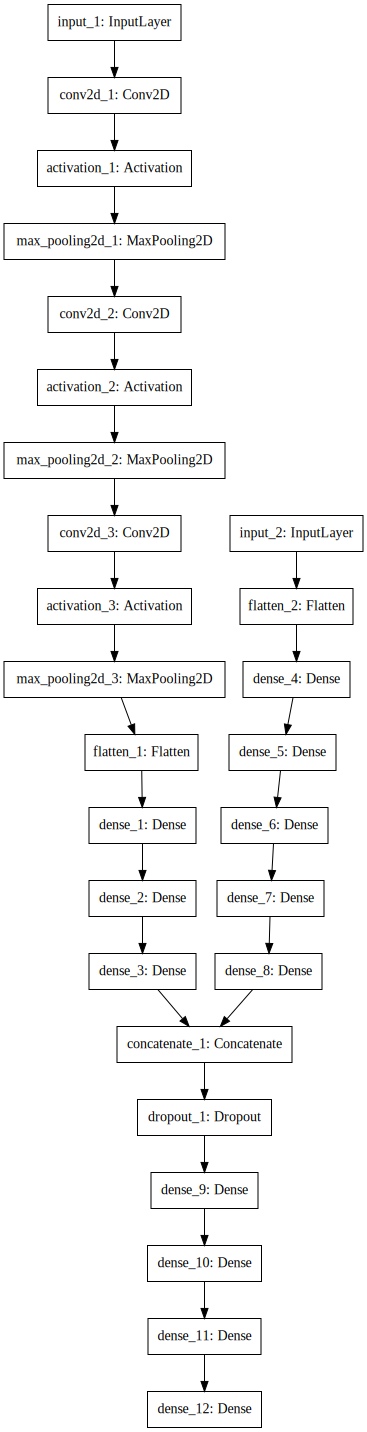

In [ ]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

def visualize_model(model):
  return model_to_dot(model).create(prog='dot', format='svg')

model_diagram = visualize_model(model)

with open('../images/adj-feat-architecture-cnn.svg', 'wb') as f:
    f.write(model_diagram)

SVG(model_diagram)

In [ ]:
training_batch_generator = SparseToDenseGenerator(adj_train, feat_train, labels_train, batch_size)
val_batch_generator = SparseToDenseGenerator(adj_test, feat_test, labels_test, batch_size)

history = model.fit_generator(
    generator=training_batch_generator,
    validation_data=val_batch_generator, 
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/5
168/168 [==============================] - 2822s 17s/step - loss: 0.6251 - acc: 0.6159 - val_loss: 0.4854 - val_acc: 0.7368
Epoch 2/5
168/168 [==============================] - 2758s 16s/step - loss: 0.3784 - acc: 0.8097 - val_loss: 0.3015 - val_acc: 0.8391
Epoch 3/5
168/168 [==============================] - 2935s 17s/step - loss: 0.1989 - acc: 0.9072 - val_loss: 0.1382 - val_acc: 0.9585
Epoch 4/5
168/168 [==============================] - 2861s 17s/step - loss: 0.1205 - acc: 0.9486 - val_loss: 0.0936 - val_acc: 0.9774
Epoch 5/5
168/168 [==============================] - 2846s 17s/step - loss: 0.0970 - acc: 0.9567 - val_loss: 0.0892 - val_acc: 0.9755


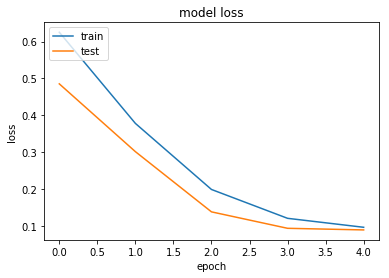

In [ ]:
import matplotlib.pyplot as plt
import numpy

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
with open('../data/adjacency-feature-matrix-history.pickle', 'wb') as f:
    pickle.dump(history,f)

In [0]:
with open('../data/adjacency-feature-matrix-model-binary.pickle', 'wb') as f:
    pickle.dump(model,f)

# Evaluation

In [ ]:
model = None

with open('../data/adjacency-feature-matrix-model-binary.pickle', 'rb') as f:
    model = pickle.load(f)

W0826 09:05:55.950369 140266623592320 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [ ]:
test_batch_generator = SparseToDenseGenerator(adj_test, feat_test, labels_test, batch_size)

model.evaluate_generator(
    generator=test_batch_generator,
)

[0.08919961298068192, 0.9755114696813679]

# Visualisations

In [0]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [0]:
class SparseToDensePredictGenerator(keras.utils.Sequence):

    def __init__(self, sparse_adjs, sparse_feats, batch_size):
        self.sparse_adjs = sparse_adjs
        self.sparse_feats = sparse_feats
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.sparse_feats) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse_adjs = self.sparse_adjs[start_index:end_index]
        batch_sparse_feats = self.sparse_feats[start_index:end_index]
        
        batch_dense_adjs = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse_adjs])
        batch_dense_feats = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse_feats])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense_adjs = np.reshape(batch_dense_adjs, batch_dense_adjs.shape + (1, ))
        batch_dense_feats = np.reshape(batch_dense_feats, batch_dense_feats.shape + (1, ))

        return [batch_dense_adjs, batch_dense_feats]

In [0]:
predict_batch_generator = SparseToDensePredictGenerator(adj_test, feat_test, batch_size)
y_predict = model.predict_generator(predict_batch_generator)

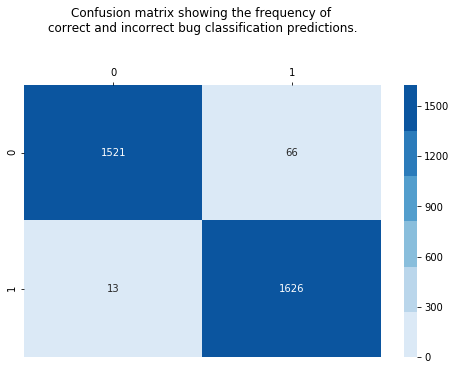

In [ ]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(labels_test, np.rint(y_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [0]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, matthews_corrcoef, f1_score, roc_auc_score
fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels_test, y_predict)
precision, recall, thresholds = precision_recall_curve(labels_test, y_predict)

In [0]:
auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score(labels_test, y_predict)
pr_auc = auc(recall, precision)
f1 = f1_score(labels_test, np.rint(y_predict))
mcc = matthews_corrcoef(labels_test, np.rint(y_predict))

In [ ]:
print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.993
ROC AUC: 0.995
MCC: 0.951
F1: 0.976


In [0]:
with open('../data/cnn-adj-feat-y-test','wb') as f:
    pickle.dump(labels_test.astype(int), f)
    
with open('../data/cnn-adj-feat-y-predict','wb') as f:
    pickle.dump(y_predict, f)

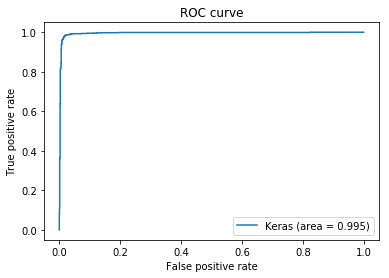

In [ ]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    labels_test.astype(int), 
    np.rint(y_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

In [ ]:
fpr_nn, fnr_nn

(0.03900709219858156, 0.00847457627118644)

## Random Padding (translational invariance)

Preprocess Dataset

In [0]:
import random

def random_padder(testcase, matrix_kind, target_rows, target_columns):
    '''
    Randomly pads matrix with zeros to the desired size
    '''
    
#     import pdb; pdb.set_trace()
    
    rand = testcase.random_pad_amount
    
    if matrix_kind == 'adj':
    
      matrix = testcase.adjacency_matrix
      
      rows, columns = matrix.shape[0], matrix.shape[1]
    
      tl_row_corrector = csr_matrix((rand-rows, rows))
      tl_col_corrector = csr_matrix((rand, rand-columns))
    
      tl_matrix = vstack([tl_row_corrector, matrix])
      tl_matrix = hstack([tl_col_corrector, tl_matrix])
    
      rows, columns = tl_matrix.shape[0], tl_matrix.shape[1]
    
      br_row_corrector = csr_matrix((target_rows-rows, rows))
      br_col_corrector = csr_matrix((target_columns, target_columns-columns))

      br_matrix = vstack([tl_matrix, br_row_corrector])
      br_matrix = hstack([br_matrix, br_col_corrector])   
    
    elif matrix_kind == 'feat':
      
      matrix = testcase.feature_matrix
      
      rows, columns = matrix.shape[0], matrix.shape[1]
    
      tl_row_corrector = csr_matrix((rand-rows, columns))
    
      tl_matrix = vstack([tl_row_corrector, matrix])
    
      rows, columns = tl_matrix.shape[0], tl_matrix.shape[1]
    
      br_row_corrector = csr_matrix((target_rows-rows, columns))

      br_matrix = vstack([tl_matrix, br_row_corrector])

    br_matrix = br_matrix.astype(np.int)
    
    return br_matrix

In [0]:
rand_adj_df = orig_df.copy()

In [0]:
rand_adj_df['padded_adj_matrix'] = rand_adj_df.apply(lambda m: random_padder(m, 'adj', matrix_size, matrix_size), axis = 1)

In [0]:
rand_feat_df = orig_df.copy()

In [0]:
rand_feat_df['padded_feat_matrix'] = rand_feat_df.apply(lambda m: random_padder(m, 'feat', matrix_size, num_features), axis = 1)

Training on standard padded, testing on randomly padded:

In [0]:
testcase_ids_rand = orig_df['testcase_ID'].values
adjacency_matrices_rand = rand_adj_df['padded_adj_matrix'].values
feature_matrices_rand = rand_feat_df['padded_feat_matrix'].values
labels_rand = orig_df['bug'].values

In [0]:
adj_train_rand, adj_test_rand, feat_train_rand, feat_test_rand, labels_train_rand, labels_test_rand = train_test_split(adjacency_matrices_rand, feature_matrices_rand, labels_rand, test_size=0.2, random_state=0)

In [0]:
test_batch_generator_rand = SparseToDenseGenerator(adj_test_rand, feat_test_rand, labels_test_rand, batch_size)

model.evaluate_generator(
    generator=test_batch_generator_rand,
)

51% accuracy when testing on the randomly padded when model was trained on normal padded

Visualisations:

In [0]:
predict_batch_generator_rand = SparseToDensePredictGenerator(adj_test_rand, feat_test_rand, batch_size)
y_predict_rand = model.predict_generator(predict_batch_generator_rand)

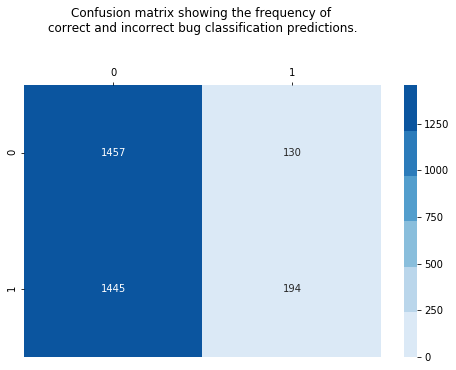

In [0]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(labels_test, np.rint(y_predict_rand)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [0]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels_test_rand.astype(int), y_predict_rand)
precision, recall, thresholds = precision_recall_curve(labels_test_rand.astype(int), y_predict_rand)

In [0]:
auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score(labels_test_rand.astype(int), y_predict_rand)
pr_auc = auc(recall, precision)
f1 = f1_score(labels_test_rand.astype(int), np.rint(y_predict_rand))
mcc = matthews_corrcoef(labels_test_rand.astype(int), np.rint(y_predict_rand))

print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.583
ROC AUC: 0.518
MCC: 0.061
F1: 0.198


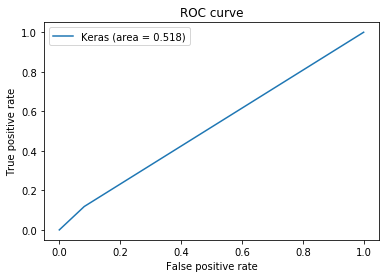

In [0]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Basically, no better than a random guess.

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    labels_test.astype(int), 
    np.rint(y_predict_rand)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

In [0]:
fpr_nn, fnr_nn

(0.4012345679012346, 0.49793246037215716)

Now we will use random padding for both training and testing:

# To DO: run model

In [0]:
# 1st: Convolutional Network on Adjacency Matrix
adjacency_input = keras.layers.Input(shape=(matrix_size, matrix_size, 1))

conv1 = Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
)(adjacency_input)
activation1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(kernel_size, padding='same')(activation1)

conv2 = Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
)(pool1)
activation2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(kernel_size, padding='same')(activation2)

conv3 = Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
)(pool2)
activation3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(kernel_size, padding='same')(activation3)

flatten = Flatten()(pool3)

dense1 = Dense(units=32, activation='relu')(flatten)
dense2 = Dense(units=32, activation='relu')(dense1)
dense3 = Dense(units=32, activation='relu')(dense2)

conv_model = keras.models.Model(inputs=adjacency_input, outputs=dense3)

# 2nd: Dense, Linear Network on Feature Matrix
features_input = keras.layers.Input(shape=(matrix_size, num_features, 1))

f_flatten = Flatten(data_format='channels_last')(features_input)

f_dense1 = Dense(units=614, activation='relu')(f_flatten)
f_dense2 = Dense(units=307, activation='relu')(f_dense1)
f_dense3 = Dense(units=150, activation='relu')(f_dense2)
f_dense4 = Dense(units=75, activation='relu')(f_dense3)
f_dense5 = Dense(units=32, activation='relu')(f_dense4)

dense_input = keras.models.Model(inputs = features_input, outputs= f_dense5)

# Combine outputs of both networks via a set of dense, linear layers
concat = keras.layers.concatenate(inputs=[conv_model.output ,dense_input.output])
c_dropout = Dropout(0.8)(concat)
c_dense1 =  Dense(units=64, activation='relu')(c_dropout)
c_dense2 =  Dense(units=64, activation='relu')(c_dense1)
c_dense3 =  Dense(units=64, activation='relu')(c_dense2)

# Dropout and final output layer
c_output = Dense(units=1, activation='sigmoid')(c_dense3)

model_rand = keras.models.Model(inputs=[conv_model.input, dense_input.input], outputs=c_output)

model_rand.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model_rand.summary()

In [ ]:
training_batch_generator_rand = SparseToDenseGenerator(adj_train_rand, feat_train_rand, labels_train_rand, batch_size)
val_batch_generator_rand = SparseToDenseGenerator(adj_test_rand, feat_test_rand, labels_test_rand, batch_size)

history_rand = model_rand.fit_generator(
    generator=training_batch_generator_rand,
    validation_data=val_batch_generator_rand,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/5
168/168 [==============================] - 2771s 16s/step - loss: 0.6691 - acc: 0.5734 - val_loss: 0.6597 - val_acc: 0.5964
Epoch 2/5
168/168 [==============================] - 2989s 18s/step - loss: 0.5858 - acc: 0.6648 - val_loss: 0.6345 - val_acc: 0.6221
Epoch 3/5
168/168 [==============================] - 2936s 17s/step - loss: 0.4681 - acc: 0.7449 - val_loss: 0.6107 - val_acc: 0.6748
Epoch 4/5
168/168 [==============================] - 3029s 18s/step - loss: 0.3867 - acc: 0.7951 - val_loss: 0.6138 - val_acc: 0.6882
Epoch 5/5
168/168 [==============================] - 3084s 18s/step - loss: 0.3046 - acc: 0.8439 - val_loss: 0.7822 - val_acc: 0.7089


In [0]:
with open('../data/adjacency-feature-matrix-random-padding-history.pickle', 'wb') as f:
    pickle.dump(history,f)

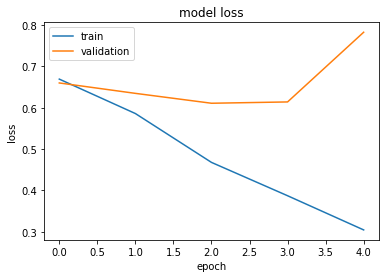

In [ ]:
import matplotlib.pyplot as plt
import numpy
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
with open('../data/adjacency-feature-matrix-random-padding-model-binary.pickle', 'wb') as f:
    pickle.dump(model_rand,f)

Load model_rand

In [0]:
model_rand = None

with open('../data/adjacency-feature-matrix-random-padding-model-binary.pickle', 'rb') as f:
    model_rand = pickle.load(f)

In [44]:
test_batch_generator_rand = SparseToDenseGenerator(adj_test_rand, feat_test_rand, labels_test_rand, batch_size)

model_rand.evaluate_generator(
    generator=test_batch_generator_rand,
)

[0.7821643684343456, 0.7089274627262218]

70.89% accuracy
(used to be 88.7% accuracy)

Visualisations:

In [0]:
predict_batch_generator_rand = SparseToDensePredictGenerator(adj_test_rand, feat_test_rand, batch_size)
y_predict_rand = model_rand.predict_generator(predict_batch_generator_rand)

In [50]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(labels_test_rand, np.rint(y_predict_rand)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

NameError: ignored

In [0]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, matthews_corrcoef, f1_score, roc_auc_score
fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels_test_rand.astype(int), y_predict_rand)
precision, recall, thresholds = precision_recall_curve(labels_test_rand.astype(int), y_predict_rand)

In [52]:
auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score(labels_test_rand.astype(int), y_predict_rand)
pr_auc = auc(recall, precision)
f1 = f1_score(labels_test_rand.astype(int), np.rint(y_predict_rand))
mcc = matthews_corrcoef(labels_test_rand.astype(int), np.rint(y_predict_rand))

print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.745
ROC AUC: 0.772
MCC: 0.427
F1: 0.743


In [0]:
with open('../data/cnn-adj-feat-rand-pad-y-test','wb') as f:
    pickle.dump(labels_test.astype(int), f)
    
with open('../data/cnn-adj-feat-rand-pad-y-predict','wb') as f:
    pickle.dump(y_predict_rand, f)

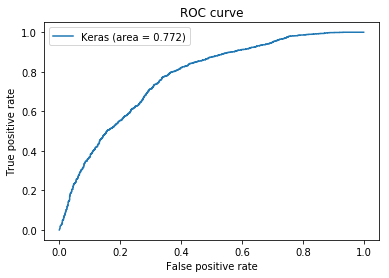

In [57]:
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    labels_test.astype(int), 
    np.rint(y_predict_rand)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

fpr_nn, fnr_nn

Now testing the model on standard padded matrices when trained on random padding:

In [0]:
test_batch_generator = SparseToDenseGenerator(adj_test, feat_test, labels_test, batch_size)

model.evaluate_generator(
    generator=test_batch_generator,
)

[5.511991235090942, 0.5365778041861475]

53.65% accuracy